In [1]:
import gesture_model
import torch
import image_dataset_loader
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt

In [2]:
EPOCHS = 3
batch_size = 8

In [3]:
train_dataset, val_dataset, test_dataset = image_dataset_loader.create_datasets('new_train_data/data/', transform = True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

tensor(3)


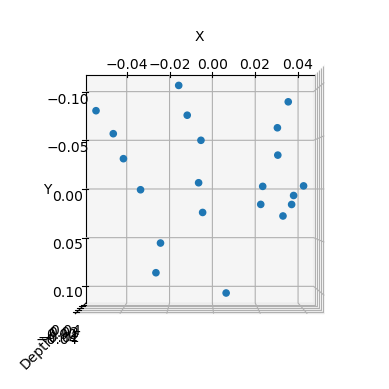

In [4]:
for i, info in enumerate(train_loader):
    landmarks, labels = info
    
    print(labels[0])
    shaped = landmarks[0].to('cpu').view(1, 21, 2)
    for i in range(shaped.shape[0]):
        x, y = zip(*shaped[i])

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(x, y)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Depth')
        ax.view_init(elev=-90, azim=-90)
        plt.show()
    break

the old version processed the images every epoch causing one epoch to be:
    trained in X seconds
training on all epochs yielded an accuracy of X2


after changing it so the training dataset has pre-processed, flattened landmarks, one epoch only:
    takes Y seconds
and yielded an accuracy of Y2

this is a Z% improvement

In [5]:
torch.set_default_dtype(torch.float32)
model = gesture_model.GestureModel(6)
model = model.float().to('cuda')

for param in model.parameters():
    if param.dtype != torch.float32:
        print(f"Found a tensor with dtype {param.dtype}")

x = torch.randn(2, 42).float().to('cuda')
output = model(x)
assert output.shape == torch.Size((2, 6)), 'the output shape is wrong ' + str(output.shape)

print(f'In {x.shape} Out {output.shape}')

In torch.Size([2, 42]) Out torch.Size([2, 6])


In [6]:
torch.set_default_dtype(torch.float32)
model = gesture_model.GestureModel(6)
model = model.float().to('cuda')
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.00001, momentum=.9)

In [7]:
def train_model_one_epoch():
    epoch_loss = 0.
    debug_print_loss = 0.
    total_accuracy = 0
    total_f1 = 0
    total_samples = 0

    for i, data in enumerate(train_loader):
        img_path, label = data

        label = label.to('cuda')

        optimizer.zero_grad()
    
        # flattened = torch.from_numpy(image_dataset_loader.process_image(img_path, label, True)).to(torch.float32).to('cuda')
        # print(data)
        forward = model(img_path.to('cuda'))

        cur_loss = loss(forward, label)
        cur_loss.backward()

        epoch_loss += cur_loss.item()
        if i % 5 == 0:
            debug_print_loss = epoch_loss / 10
            epoch_loss = 0
            print('  batch {} loss {}'.format(i + 1, debug_print_loss))
        total_accuracy += accuracy(forward, label) * label.size(0)
        total_f1 += compute_f1(forward, label) * label.size(0)
        total_samples += label.size(0)
    
    epoch_accuracy = total_accuracy / total_samples
    epoch_f1 = total_f1 / total_samples
    print(f"Epoch Accuracy: {epoch_accuracy:.4f}, Epoch F1: {epoch_f1:.4f}")
    return debug_print_loss

In [8]:
from sklearn.metrics import f1_score
def accuracy(output, target):
    """Compute the accuracy for the current batch."""
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / target.size(0)

def compute_f1(output, target):
    """Compute the F1 score for the current batch."""
    _, predicted = torch.max(output, 1)
    predicted = predicted.detach().cpu().numpy()
    target = target.cpu().numpy()
    return f1_score(target, predicted, average='macro')  # 'macro' can be replaced by 'micro' or 'weighted' based on preference

In [9]:
cur_epoch = 0
best_val_loss = 1_000_000
writer = SummaryWriter()

for epoch in range(EPOCHS):
    print(f'EPOCH {cur_epoch + 1}')

    model.train(True)
    epoch_loss = train_model_one_epoch()

    running_val_loss = 0.0
    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to('cuda')
            vlabels = vlabels.to('cuda')
            voutputs = model(vinputs)
            voutputs = voutputs.to('cuda')
            vloss = loss(voutputs, vlabels)
            running_val_loss += vloss
    
    avg_vloss = running_val_loss / (i + 1)
    print(f'(LOSS) EPOCH {epoch}: train {epoch_loss} val {avg_vloss}')
    writer.add_scalar('training loss', epoch_loss, epoch * len(train_loader) + i)

    if avg_vloss < best_val_loss:
        best_val_loss = avg_vloss
        model_path = f'models/model_1_{epoch}'
    cur_epoch += 1
writer.close()

EPOCH 1
  batch 1 loss 0.20970349311828612
  batch 6 loss 1.0671327352523803
  batch 11 loss 1.0725082397460937
Epoch Accuracy: 0.1176, Epoch F1: 0.0976
(LOSS) EPOCH 0: train 1.0725082397460937 val 1.7989943027496338
EPOCH 2
  batch 1 loss 0.206162166595459
  batch 6 loss 1.0426716804504395
  batch 11 loss 1.089301300048828
Epoch Accuracy: 0.1412, Epoch F1: 0.1202
(LOSS) EPOCH 1: train 1.089301300048828 val 1.804726004600525
EPOCH 3
  batch 1 loss 0.20279331207275392
  batch 6 loss 1.0974499225616454
  batch 11 loss 1.0419327855110168
Epoch Accuracy: 0.0824, Epoch F1: 0.0757
(LOSS) EPOCH 2: train 1.0419327855110168 val 1.81392502784729


  batch 16 loss 1.2938590049743652
Epoch Accuracy: 0.1036, Epoch F1: 0.0694
(LOSS) EPOCH 2: train 1.2938590049743652 val 2.701719045639038

it finally reached 10% accuracy

In [11]:
for ind, info in enumerate(val_dataset):
    path, lab = info

    print(lab)
    y_pred = model(path.reshape((1, 84)))
    # print(path)
    print(torch.nn.functional.softmax(y_pred, dim=1))

0
tensor([[0.0866, 0.0699, 0.0781, 0.0749, 0.0728, 0.0673, 0.0627, 0.0698, 0.0810,
         0.0653, 0.0705, 0.0650, 0.0738, 0.0622]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
0
tensor([[0.0866, 0.0700, 0.0781, 0.0749, 0.0728, 0.0673, 0.0627, 0.0698, 0.0806,
         0.0654, 0.0706, 0.0651, 0.0739, 0.0622]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
0
tensor([[0.0863, 0.0700, 0.0778, 0.0754, 0.0730, 0.0675, 0.0625, 0.0702, 0.0805,
         0.0655, 0.0702, 0.0650, 0.0739, 0.0622]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
1
tensor([[0.0854, 0.0671, 0.0753, 0.0773, 0.0770, 0.0684, 0.0627, 0.0724, 0.0754,
         0.0632, 0.0704, 0.0679, 0.0742, 0.0633]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
1
tensor([[0.0860, 0.0663, 0.0737, 0.0772, 0.0753, 0.0677, 0.0632, 0.0734, 0.0759,
         0.0643, 0.0717, 0.0689, 0.0737, 0.0627]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
1
tensor([[0.0871, 0.0702, 0.0782, 0.0744, 0.0709, 0.0665, 0.0650, 0.0